# A description of the problem and a discussion of the background

As a Chinese student living in Paris, I like to eat Chinese food and drink Bubble Tea (just like most Chinese students).
But not every Chinese restaurant has a tea shop nearby. Sometimes it takes more than 30 minutes to reach the tea shop after the meal.
With the increasing number of Chinese students studying in Paris, the number of tea shops will increase.
In this project, I combined the information of the existing Chinese restaurants and tea shops in Paris, and recommended the address for opening the new bubble tea shop for investment merchants.
Investors in the restaurant industry in Paris will be very emotional about this report.

# A description of the data and how it will be used to solve the problem 

Data information used:
The location of the existing Chinese restaurant in Paris.（From foursquare）
The location of the existing tea shop in Paris.（From foursquare）

Since the habit of most Chinese students is to buy a cup of milk tea after eating, the location of the new tea shop should be chosen near the existing Chinese restaurant and away from the existing tea shop to avoid excessive competition.

I will synthesize information about existing Chinese restaurants and tea shops, and then use machine learning methods (mainly k-means) to recommend the address of the new tea shop.

# Methodology section which represents the main component of the report where discuss and describe exploratory data analysis, inferential statistical testing, if any, and what machine learnings were used and why.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes
import folium
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.3 MB

The following NEW packages will be 

In [2]:
address = 'Paris, FR'
geolocator = Nominatim(user_agent="Paris")
location = geolocator.geocode(address)
latitude_paris = location.latitude
longitude_paris = location.longitude
print('Geograpical coordinate of Paris are {}, {}.'.format(latitude_paris, longitude_paris))

Geograpical coordinate of Paris are 48.8566101, 2.3514992.


In [3]:
map_paris = folium.Map(location=[latitude_paris, longitude_paris], zoom_start=12)
# for lat, lng, borough, Neighbourhood in zip(Toronto_df['Latitude'], Toronto_df['Longitude'], Toronto_df['Borough'], Toronto_df['Neighbourhood']):
# label = '{}, {}'.format(Neighbourhood, borough)
# label = folium.Popup(label, parse_html=True)
folium.CircleMarker(
    [latitude_paris, longitude_paris],
    radius=5,
    #popup=label,
    color='black',
    fill=True,
    fill_color='black',
    fill_opacity=0.7,
    parse_html=False).add_to(map_paris)  
map_paris

Here we can see the map of paris.

In [4]:
CLIENT_ID = 'NHEWGEHMDWV5MXXHZASZZK5K1VUEAXQEH2HWEB5OZQBLGVUR' # your Foursquare ID
CLIENT_SECRET = 'YXMOA4O3IBZA1XAQW3DASF14NE2TGPSFL1JREACVOWSS1E0C' # your Foursquare Secret
VERSION = '20180928' # Foursquare API version
categoryId = '4bf58dd8d48988d145941735'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NHEWGEHMDWV5MXXHZASZZK5K1VUEAXQEH2HWEB5OZQBLGVUR
CLIENT_SECRET:YXMOA4O3IBZA1XAQW3DASF14NE2TGPSFL1JREACVOWSS1E0C


In [5]:
LIMIT = 50
radius = 100000

url = 'https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d145941735&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    location.latitude, 
    location.longitude, 
    radius,
    LIMIT
    )
url

'https://api.foursquare.com/v2/venues/search?categoryId=4bf58dd8d48988d145941735&client_id=NHEWGEHMDWV5MXXHZASZZK5K1VUEAXQEH2HWEB5OZQBLGVUR&client_secret=YXMOA4O3IBZA1XAQW3DASF14NE2TGPSFL1JREACVOWSS1E0C&v=20180928&ll=48.8566101,2.3514992&radius=100000&limit=50'

categoryId=4bf58dd8d48988d145941735 represents information about only the chinese restaurant

In [6]:
results = requests.get(url).json()
#results

See all the Chinese restaurants in Paris

In [7]:
from pandas.io.json import json_normalize
venues = results['response']['venues']

In [9]:
nearby_venues = json_normalize(venues) 
nearby_venues.head()
nearby_venues.shape
nearby_venues.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.neighborhood,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",False,58e6b9a20aac7515afa6686a,170 rue Saint-Martin,FR,Paris,France,NaN,590,"[170 rue Saint-Martin, 75003 Paris, France]","[{'label': 'display', 'lat': 48.8619, 'lng': 2...",48.861900,2.352130,Temple,75003,Île-de-France,Cinq Fois Plus,v-1572019109,440156233
1,"[{'id': '52af3a7c3cf9994f4e043bed', 'name': 'C...",False,4b4afbb7f964a520839026e3,17 rue Saint-Jacques,FR,Paris,France,NaN,671,"[17 rue Saint-Jacques, 75005 Paris, France]","[{'label': 'display', 'lat': 48.85175467726327...",48.851755,2.346066,NaN,75005,Île-de-France,Mirama,v-1572019109,NaN
2,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",False,5b1711443e70ff0024982a31,69 rue du Faubourg Poissonnière,FR,Paris,France,NaN,2157,"[69 rue du Faubourg Poissonnière, 75009 Paris,...","[{'label': 'display', 'lat': 48.875868, 'lng':...",48.875868,2.348158,NaN,75009,Île-de-France,Nouilles Ceintures,v-1572019109,NaN
3,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",False,4c0e8811d64c0f47d958285d,6 rue de Monttessuy,FR,Paris,France,NaN,3777,"[6 rue de Monttessuy, 75007 Paris, France]","[{'label': 'display', 'lat': 48.85972472655788...",48.859725,2.300136,NaN,75007,Île-de-France,Chez Ming,v-1572019109,NaN
4,"[{'id': '4bf58dd8d48988d145941735', 'name': 'C...",False,53061a18498e089e13238604,14 rue de Buci,FR,Paris,France,NaN,1102,"[14 rue de Buci, 75006 Paris, France]","[{'label': 'display', 'lat': 48.85379686850624...",48.853797,2.337072,NaN,75006,Île-de-France,Délices de Buci,v-1572019109,NaN


In [10]:
filtered_columns = ['name',  'location.lat', 'location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()


,name,location.lat,location.lng
0,Cinq Fois Plus,48.861900,2.352130
1,Mirama,48.851755,2.346066
2,Nouilles Ceintures,48.875868,2.348158
3,Chez Ming,48.859725,2.300136
4,Délices de Buci,48.853797,2.337072


Get location information for Chinese restaurant

In [11]:
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,lat,lng
0,Cinq Fois Plus,48.861900,2.352130
1,Mirama,48.851755,2.346066
2,Nouilles Ceintures,48.875868,2.348158
3,Chez Ming,48.859725,2.300136
4,Délices de Buci,48.853797,2.337072


In [12]:
map_paris1 = folium.Map(location=[latitude_paris, longitude_paris], zoom_start=12)
for lat, lng, name in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris1)  
map_paris1

The green dots represent the distribution of Chinese restaurants in Paris.

In [13]:
url2 = 'https://api.foursquare.com/v2/venues/search?categoryId=52e81612bcbc57f1066b7a0c&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    location.latitude, 
    location.longitude, 
    radius,
    LIMIT
    )
url2


'https://api.foursquare.com/v2/venues/search?categoryId=52e81612bcbc57f1066b7a0c&client_id=NHEWGEHMDWV5MXXHZASZZK5K1VUEAXQEH2HWEB5OZQBLGVUR&client_secret=YXMOA4O3IBZA1XAQW3DASF14NE2TGPSFL1JREACVOWSS1E0C&v=20180928&ll=48.8566101,2.3514992&radius=100000&limit=50'

categoryId=52e81612bcbc57f1066b7a0 represents information about only the Bubble Tea Shop

In [14]:
results2 = requests.get(url2).json()
#results2

In [15]:
venues2 = results2['response']['venues']
nearby_venues2 = json_normalize(venues2) 
nearby_venues2.head()
nearby_venues2.shape



(47, 19)

In [16]:
nearby_venues2 =nearby_venues2.loc[:, filtered_columns]
nearby_venues2.head()

,name,location.lat,location.lng
0,Bubbolitas - Bubble Tea Bar,48.859863,2.349793
1,Laïzé 來座 (Laïzé),48.863077,2.355073
2,Yi Yun,48.866037,2.335741
3,Chamie Bubble Tea,48.851519,2.346061
4,The Alley,48.867272,2.334809


In [17]:
nearby_venues2.columns = [col.split(".")[-1] for col in nearby_venues2.columns]

nearby_venues2.head()

,name,lat,lng
0,Bubbolitas - Bubble Tea Bar,48.859863,2.349793
1,Laïzé 來座 (Laïzé),48.863077,2.355073
2,Yi Yun,48.866037,2.335741
3,Chamie Bubble Tea,48.851519,2.346061
4,The Alley,48.867272,2.334809


Get location information for Bubble Tea Shop

In [18]:
#map_paris2 = folium.Map(location=[latitude_paris, longitude_paris], zoom_start=12)
for lat, lng, name in zip(nearby_venues2['lat'], nearby_venues2['lng'], nearby_venues2['name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris1)  
map_paris1

The red dots represent the distribution of the tea shop.

In [19]:
nearby_venues.head()

,name,lat,lng
0,Cinq Fois Plus,48.861900,2.352130
1,Mirama,48.851755,2.346066
2,Nouilles Ceintures,48.875868,2.348158
3,Chez Ming,48.859725,2.300136
4,Délices de Buci,48.853797,2.337072


In [20]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
import math

In [21]:
# Calculate the distance from each Chinese restaurant to the nearest tea shop
def least_distance(x,y,nearby_venues2):
    all_distance = []
    for lat,lng in zip(nearby_venues2['lat'], nearby_venues2['lng']):
        distance = math.pow((x-lat),2)+math.pow((y-lng),2)
        distance = 10000000*distance
        distance = math.sqrt(distance)
        all_distance.append(distance)
    return min(all_distance)
    

In [22]:
# Test if the above function is valid
min_distance = []
x = 48.857349
y = 2.350227
a = least_distance(x,y,nearby_venues2)
print(a)

8.065768980626453


In [23]:
# Get the distance from all the Chinese restaurants to the nearest tea shop
for lat, lng in zip(nearby_venues['lat'], nearby_venues['lng']):
    dis = least_distance(lat,lng,nearby_venues2)
    min_distance.append(dis)

In [24]:
min_distance[0:5]

[1.725539345510995,
 0.7443319459967218,
 16.96090681538012,
 23.57145165175261,
 3.5579533551018723]

In [28]:
# Add distance information to the restaurant information table
near_Res  = nearby_venues
near_Res['min_distance']=min_distance

In [29]:
near_Res

,name,lat,lng,min_distance
0,Cinq Fois Plus,48.861900,2.352130,1.725539
1,Mirama,48.851755,2.346066,0.744332
2,Nouilles Ceintures,48.875868,2.348158,16.960907
3,Chez Ming,48.859725,2.300136,23.571452
4,Délices de Buci,48.853797,2.337072,3.557953
5,Petit Bao,48.864381,2.350274,7.977212
6,La Cantine Chinoise Wenzhou,48.872506,2.378871,43.362492
7,La Fontaine de Jade,48.855494,2.304727,36.333003
8,Maison Zhang,48.877609,2.339416,10.786698
9,Délices Lepic,48.884706,2.333694,24.165722


In [30]:
X= near_Res[['lat','lng','min_distance']]
X[0:5]

,lat,lng,min_distance
0,48.861900,2.352130,1.725539
1,48.851755,2.346066,0.744332
2,48.875868,2.348158,16.960907
3,48.859725,2.300136,23.571452
4,48.853797,2.337072,3.557953


In [31]:
# Normalize the data
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.12356001, -0.06550636, -0.26127417],
       [ 0.04290059, -0.16208201, -0.26529504],
       [ 0.23461125, -0.12876267, -0.19884148],
       [ 0.1062657 , -0.89353636, -0.17175227],
       [ 0.05913684, -0.30531799, -0.25376516]])

In [36]:
# Classify data using the k-means algorithm
k_means = KMeans(init="k-means++", n_clusters=5, n_init=40)
k_means.fit(X)
k_means_labels = k_means.labels_
k_means_labels

array([0, 0, 0, 2, 0, 0, 4, 2, 0, 0, 0, 4, 4, 1, 4, 0, 4, 4, 0, 3, 0, 2,
       0, 0, 0, 3, 2, 4, 4, 4, 0, 4, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4,
       0, 0, 4, 0, 4, 2], dtype=int32)

# Results section where discuss the results.

In [37]:
# Add category information to the restaurant information table
near_final = near_Res.copy()
near_final['k_type']=k_means_labels
near_final

,name,lat,lng,min_distance,k_type
0,Cinq Fois Plus,48.861900,2.352130,1.725539,0
1,Mirama,48.851755,2.346066,0.744332,0
2,Nouilles Ceintures,48.875868,2.348158,16.960907,0
3,Chez Ming,48.859725,2.300136,23.571452,2
4,Délices de Buci,48.853797,2.337072,3.557953,0
5,Petit Bao,48.864381,2.350274,7.977212,0
6,La Cantine Chinoise Wenzhou,48.872506,2.378871,43.362492,4
7,La Fontaine de Jade,48.855494,2.304727,36.333003,2
8,Maison Zhang,48.877609,2.339416,10.786698,0
9,Délices Lepic,48.884706,2.333694,24.165722,0


In [38]:
map_paris3 = folium.Map(location=[latitude_paris, longitude_paris], zoom_start=12)
for lat, lng, name in zip(near_final['lat'], near_final['lng'], near_final['k_type']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    color = ''
    if name == 0:
        color = 'green'
        radius = 5
    else:
        color = 'blue'
        radius = 5+name*2
    folium.CircleMarker(
        [lat, lng],
        radius=radius,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris3)  
map_paris3

Blue dots are the recommended places to open a new tea shop. Opening a new tea shop in these places will not only ensure the number of customers (the customers who go to the Chinese restaurant are our potential customers), but also avoid the competition of existing tea shops.

Now I will use the hierarchical clustering to reprocess the data. Because this method can more clearly show the relationship between the data.
Using different algorithms for calculations can make the results more accurate.

In [75]:
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 

In [76]:
dist_matrix = distance_matrix(X,X)
Z = hierarchy.linkage(dist_matrix, 'ward')

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  from ipykernel import kernelapp as app


In [71]:
print (Z[-6:, 2])

[  6.0316268    6.13436431  10.4656859   12.30683171  22.21966349
 109.67623454]


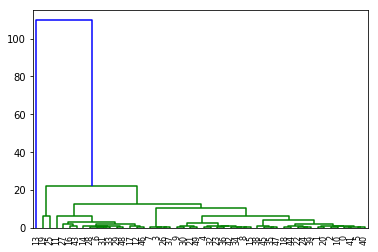

In [67]:
dendro = hierarchy.dendrogram(Z)

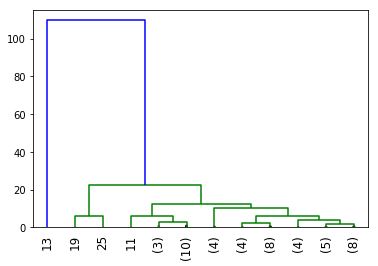

In [73]:
# Try to make the histogram clearer
dendro1 = hierarchy.dendrogram(Z, truncate_mode='lastp', p=12, show_leaf_counts=True, leaf_rotation=90., leaf_font_size=12., show_contracted=True)

Based on the information in the tree diagram, I decided to divide all the data into 5 categories.

In [78]:
# Get detailed classification of clustering data
from scipy.cluster.hierarchy import fcluster
max_d = 5
clusters = fcluster(Z, max_d, criterion='maxclust')
clusters

array([4, 4, 4, 3, 4, 4, 2, 3, 4, 4, 4, 2, 2, 5, 2, 4, 2, 2, 4, 1, 4, 4,
       4, 4, 4, 1, 3, 2, 2, 2, 4, 2, 4, 2, 4, 4, 4, 3, 4, 4, 4, 4, 4, 2,
       4, 4, 2, 4, 2, 4], dtype=int32)

In [46]:
# Compare the results obtained with the kmeans algorithm
k_means_labels

array([0, 0, 0, 2, 0, 0, 4, 2, 0, 0, 0, 4, 4, 1, 4, 0, 4, 4, 0, 3, 0, 2,
       0, 0, 0, 3, 2, 4, 4, 4, 0, 4, 0, 4, 0, 0, 0, 2, 0, 0, 0, 0, 0, 4,
       0, 0, 4, 0, 4, 2], dtype=int32)

In [79]:
near_final2 = near_Res.copy()
near_final2['k_type']=clusters
near_final2

,name,lat,lng,min_distance,k_type
0,Cinq Fois Plus,48.861900,2.352130,1.725539,4
1,Mirama,48.851755,2.346066,0.744332,4
2,Nouilles Ceintures,48.875868,2.348158,16.960907,4
3,Chez Ming,48.859725,2.300136,23.571452,3
4,Délices de Buci,48.853797,2.337072,3.557953,4
5,Petit Bao,48.864381,2.350274,7.977212,4
6,La Cantine Chinoise Wenzhou,48.872506,2.378871,43.362492,2
7,La Fontaine de Jade,48.855494,2.304727,36.333003,3
8,Maison Zhang,48.877609,2.339416,10.786698,4
9,Délices Lepic,48.884706,2.333694,24.165722,4


In [82]:
map_paris4 = folium.Map(location=[latitude_paris, longitude_paris], zoom_start=12)
for lat, lng, name in zip(near_final2['lat'], near_final2['lng'], near_final2['k_type']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    color = ''
    if name == 4:
        color = 'green'
        radius = 5
    else:
        color = 'blue'
        radius = 5+name*2
    folium.CircleMarker(
        [lat, lng],
        radius=radius,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris4)  
map_paris4

Blue dots are the recommended places to open a new tea shop.
This result is roughly the same as the result obtained by the k-means algorithm.

# Discussion section where discuss observations and recommendations based on the results.

According to this report, I recommended the address of the blue dot in the map as the address of the new tea shop.

This address takes into account the following factors:
1. The number of Chinese customers that may be nearby (based on the number of nearby Chinese restaurants)
2. Competition that may exist in existing tea shops (based on the distance from nearby tea shops)

This report can be improved as follows:
1. Try to analyze the type of occupation of the customers in the tea shop. Further refine the recommended location information.
2. Try to classify the varieties of the tea shop. Give advice on the products of the tea shop.
3. Try to join real estate rental information in different parts of Paris. Forecast the cost and profit of the tea shop.

# Conclusion section

In this project, I used machine learning algorithms to provide merchants in the restaurant industry with the opening address of the new tea shop, and this conclusion can be reasonably explained.
In this project, I successfully applied what I learned in this course. . . Data processing, machine learning, classification prediction, etc.
I am very happy to complete this series of courses because I am very interested in data science, and I also believe that data science will be more developed in the most areas of life.